## Вихров Евгений Олегови, М-26

In [28]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.spatial.distance import cosine
import cv2
import requests
from io import BytesIO
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary

# Часть 1. Локальные дескрипторы (SIFT) и backpropagation


### 1. SIFT-дескрипторы и сопоставление

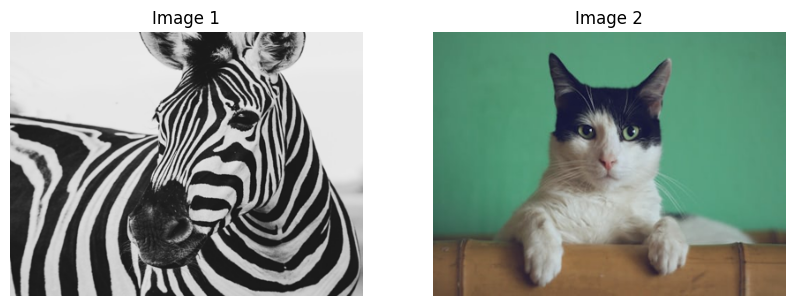

In [4]:
# Загрузка двух изображений из ImageNet
def load_image_from_url(url, size=(400, 300)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# URL примеров изображений из ImageNet
url1 = "https://images.unsplash.com/photo-1501706362039-c06b2d715385?auto=format&w=800"
url2 = "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"

img1 = load_image_from_url(url1)
img2 = load_image_from_url(url2)

plt.figure(figsize=(10, 5))

# Первое изображение
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1")
plt.axis("off")

# Второе изображение
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2")
plt.axis("off")

plt.show()


Ключевые точки на изображении 1: 619
Ключевые точки на изображении 2: 145


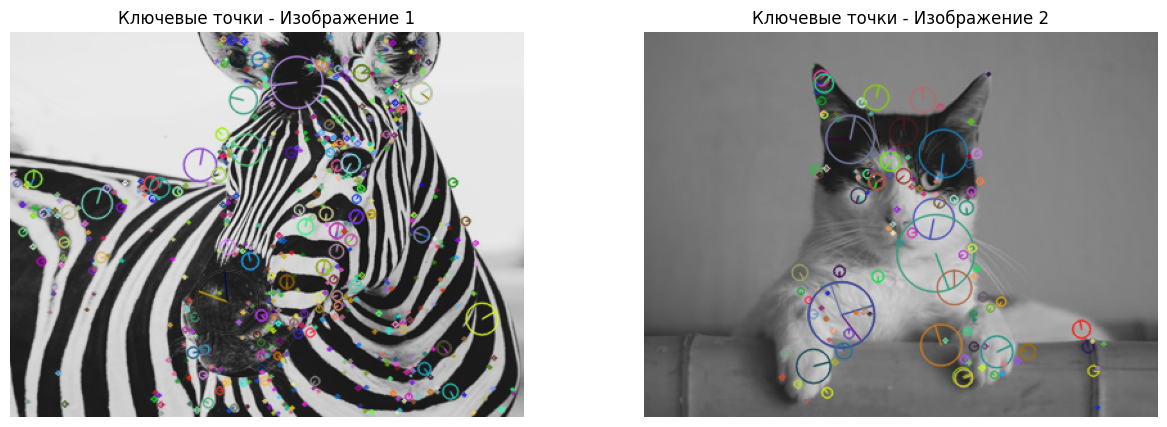

In [5]:
# Конвертация в grayscale для SIFT
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"Ключевые точки на изображении 1: {len(kp1)}")
print(f"Ключевые точки на изображении 2: {len(kp2)}")

# Визуализация ключевых точек на изображениях
img1_kp = cv2.drawKeypoints(gray1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(gray2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB))
plt.title('Ключевые точки - Изображение 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB))
plt.title('Ключевые точки - Изображение 2')
plt.axis('off')
plt.show()

Хорошие совпадения: 26


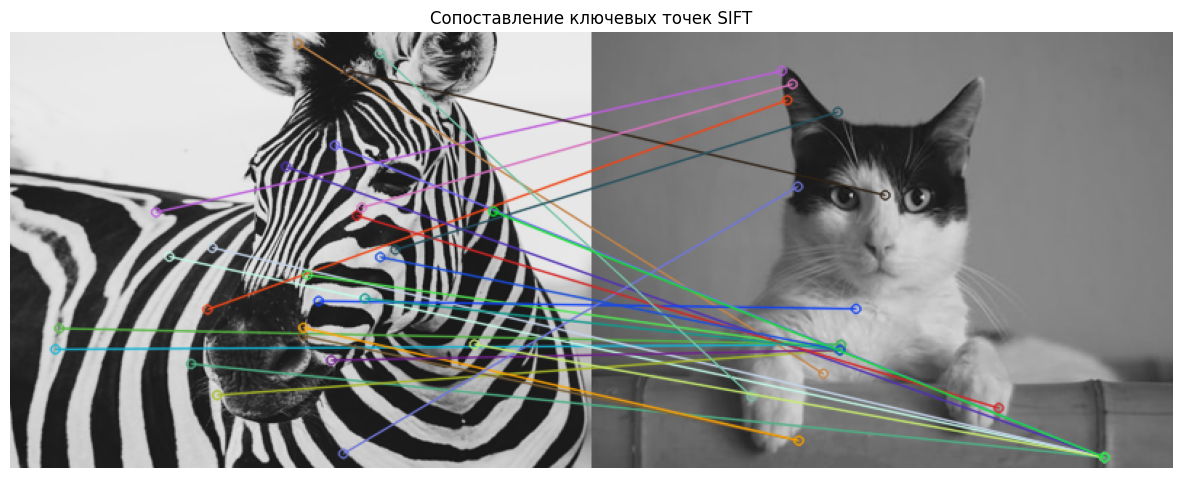

In [6]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Применяем тест Лоу
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Хорошие совпадения: {len(good_matches)}")

# Визуализация совпадений
img_matches = cv2.drawMatches(gray1, kp1, gray2, kp2, good_matches, None, flags=2)

plt.figure(figsize=(15, 8))
plt.imshow(img_matches)
plt.title('Сопоставление ключевых точек SIFT')
plt.axis('off')
plt.show()

### 2. Анализ шагов SIFT

1. **Масштабно-пространственная фильтрация**:
   - Создание гауссовой пирамиды с разными масштабами
   - Вычисление разности гауссианов (DoG) между соседними масштабами
   - Backpropagation: Производная DoG = производная по гауссовым фильтрам

2. **Выбор экстремумов (ключевых точек)**:
   - Поиск локальных экстремумов в DoG
   - Отсечение слабых точек по порогу контраста
   - Backpropagation: Недифференцируемая операция, требует специальных методов

3. **Назначение ориентаций ключевым точкам**:
   - Вычисление градиентов в окрестности ключевой точки
   - Построение гистограммы ориентаций
   - Backpropagation: Производная по градиентам ориентации

4. **Построение гистограмм градиентов**:
   - Разделение окрестности на 4x4 подрегиона
   - Для каждого подрегиона - гистограмма из 8 ориентаций
   - Backpropagation: Производная по весам гистограммы

5. **Нормализация дескрипторов**:
   - Нормализация вектора дескриптора
   - Обрезка больших значений и повторная нормализация
   - Backpropagation: Производная операции нормализации

### 3. Реализация SIFT (опционально)

1) Берем исходное изображение и постепепенно делаем его более размытым с помощью гауссовского фильтра. Нужно это для выделения деталей разного масштаба из изображения. Такие группы размытия называются октавами.

    L(x,y,σ) = G(x,y,σ) * I(x,y) где: G(x,y,σ) = (1/2πσ²) * exp(-(x²+y²)/2σ²) - Гауссово ядро 
    
    I(x,y) - исходное изображение

    

2) Для каждой октавы берем два размытых изображения и вычитаем одно из другого, тем самым получаем DoG-изображения. В местах, где имеются резкие изменения, выделяем ключевые точки.

    D(x,y,σ) = L(x,y,kσ) - L(x,y,σ)


3) Теперь в DoG-изображениях смотрим, какие точки являются точками локального максимума или минимума. Каждую точку сравниваем её со всеми соседями по x и y и соседям по уровням размытия. Если точка ярче или темнее всех своих соседей, то она считается ключевой

4) Для каждой найденной ключевой точки находим её направление, в котором градиенты вокруг наиболее выражены. Это необходимо для описания точки независимо от её поворота в изображении

    mag = √(G_x² + G_y²)

    θ = atan2(G_y, G_x)

5) Теперь вокруг каждой ключевой точки строим дискриптор следующим образом: разбиваем область вокруг точки на сетку областей, в каждой области строится гистограмма направлений градиентов, после чего гистограммы объединяются в один вектор


# Часть 2. Сверточная нейронная сеть: ResNet и затухающие градиенты

### 1. Данные из ImageNet

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes_to_use = [0, 1]  # airplane, automobile

In [15]:
# Фильтруем данные по выбранным классам
train_indices = [i for i, (_, label) in enumerate(trainset) if label in classes_to_use]
test_indices = [i for i, (_, label) in enumerate(testset) if label in classes_to_use]

train_subset = Subset(trainset, train_indices)
test_subset = Subset(testset, test_indices)

trainloader = DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = DataLoader(test_subset, batch_size=32, shuffle=False)

print(f"Размер обучающей выборки: {len(train_subset)}")
print(f"Размер тестовой выборки: {len(test_subset)}")

Размер обучающей выборки: 10000
Размер тестовой выборки: 2000


Примеры изображений из датасета:


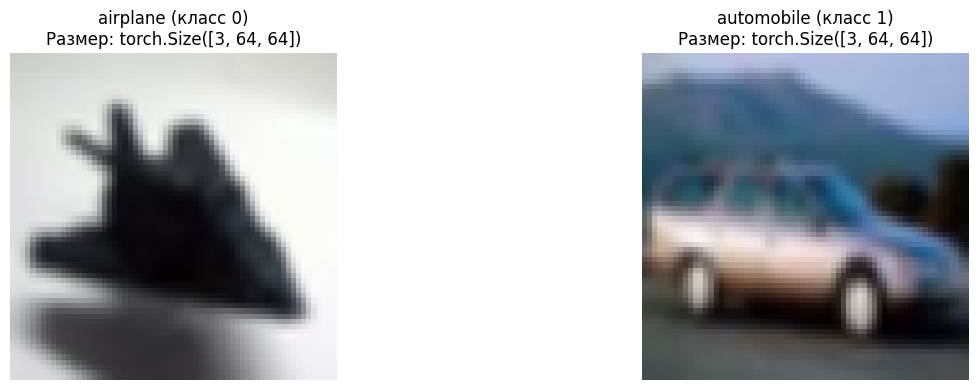


Распределение по классам:
Класс 0 (airplane): 5000 изображений
Класс 1 (automobile): 5000 изображений


In [22]:
# Визуализация примеров данных
print("Примеры изображений из датасета:")

class_names = ['airplane', 'automobile']
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for class_idx, class_name in enumerate(class_names):
    # Находим первое изображение для каждого класса
    class_example_idx = next(i for i, (_, label) in enumerate(train_subset) if label == class_idx)
    img, label = train_subset[class_example_idx]
    
    # Денормализуем изображение
    img_display = img.numpy().transpose((1, 2, 0))
    img_display = img_display * 0.5 + 0.5
    img_display = np.clip(img_display, 0, 1)
    
    axes[class_idx].imshow(img_display)
    axes[class_idx].set_title(f'{class_name} (класс {class_idx})\nРазмер: {img.shape}')
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()

# Информация о распределении классов
print("\nРаспределение по классам:")
for class_idx, class_name in enumerate(class_names):
    count = sum(1 for _, label in train_subset if label == class_idx)
    print(f"Класс {class_idx} ({class_name}): {count} изображений")

## 2. Сравнение CNN и ResNet

In [9]:
# простой CNN 
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
# ResNet

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class SimpleResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Инициализация моделей
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

simple_cnn = SimpleCNN(num_classes=3).to(device)
resnet = SimpleResNet(num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(resnet.parameters(), lr=0.001)

Используемое устройство: cuda


In [12]:
# Функции для обучения и вычисления градиентов
def train_model(model, optimizer, trainloader, testloader, epochs=10, model_name="Model"):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    gradients = []  # Будем сохранять градиенты
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(tqdm(trainloader, desc=f'{model_name} Epoch {epoch+1}')):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Сохраняем градиенты после backward()
            if batch_idx == 0:  # Сохраняем градиенты только для первого батча эпохи
                epoch_gradients = {}
                for name, param in model.named_parameters():
                    if param.grad is not None:
                        epoch_gradients[name] = param.grad.norm().item()
                gradients.append(epoch_gradients)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        
        # Валидация
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        test_loss /= len(testloader)
        test_acc = 100. * correct / total
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    return train_losses, test_losses, train_accs, test_accs, gradients

In [29]:
print("Архитектура Simple CNN:")
summary(simple_cnn, input_size=(1, 3, 64, 64), col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"])

print("\nАрхитектура ResNet:")
summary(resnet, input_size=(1, 3, 64, 64), col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"])

Архитектура Simple CNN:

Архитектура ResNet:


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
SimpleResNet                             [1, 3, 64, 64]            [1, 3]                    --                        --                        True
├─Conv2d: 1-1                            [1, 3, 64, 64]            [1, 64, 64, 64]           1,728                     [3, 3]                    True
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           [1, 64, 64, 64]           128                       --                        True
├─Sequential: 1-3                        [1, 64, 64, 64]           [1, 64, 64, 64]           --                        --                        True
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           [1, 64, 64, 64]           --                        --                        True
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           [1, 64, 64, 64]           36

In [30]:
# Обучение моделей

# Обучение CNN
cnn_train_loss, cnn_test_loss, cnn_train_acc, cnn_test_acc, cnn_gradients = train_model(
    simple_cnn, optimizer_cnn, trainloader, testloader, epochs=10, model_name="Simple CNN"
)

# Обучение ResNet
resnet_train_loss, resnet_test_loss, resnet_train_acc, resnet_test_acc, resnet_gradients = train_model(
    resnet, optimizer_resnet, trainloader, testloader, epochs=10, model_name="ResNet"
)


Simple CNN Epoch 1: 100%|██████████| 313/313 [00:02<00:00, 121.85it/s]


Epoch 1: Train Loss: 0.3845, Train Acc: 83.03%, Test Loss: 0.2117, Test Acc: 91.25%


Simple CNN Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 138.76it/s]


Epoch 2: Train Loss: 0.2053, Train Acc: 91.84%, Test Loss: 0.1815, Test Acc: 92.60%


Simple CNN Epoch 3: 100%|██████████| 313/313 [00:02<00:00, 140.03it/s]


Epoch 3: Train Loss: 0.1553, Train Acc: 94.06%, Test Loss: 0.1439, Test Acc: 93.75%


Simple CNN Epoch 4: 100%|██████████| 313/313 [00:02<00:00, 140.28it/s]


Epoch 4: Train Loss: 0.1219, Train Acc: 95.16%, Test Loss: 0.1571, Test Acc: 94.00%


Simple CNN Epoch 5: 100%|██████████| 313/313 [00:02<00:00, 140.15it/s]


Epoch 5: Train Loss: 0.0907, Train Acc: 96.60%, Test Loss: 0.1119, Test Acc: 95.80%


Simple CNN Epoch 6: 100%|██████████| 313/313 [00:02<00:00, 138.41it/s]


Epoch 6: Train Loss: 0.0710, Train Acc: 97.41%, Test Loss: 0.1266, Test Acc: 95.30%


Simple CNN Epoch 7: 100%|██████████| 313/313 [00:02<00:00, 141.08it/s]


Epoch 7: Train Loss: 0.0575, Train Acc: 97.76%, Test Loss: 0.1284, Test Acc: 95.55%


Simple CNN Epoch 8: 100%|██████████| 313/313 [00:02<00:00, 140.34it/s]


Epoch 8: Train Loss: 0.0494, Train Acc: 98.14%, Test Loss: 0.1263, Test Acc: 95.75%


Simple CNN Epoch 9: 100%|██████████| 313/313 [00:02<00:00, 137.98it/s]


Epoch 9: Train Loss: 0.0332, Train Acc: 98.89%, Test Loss: 0.1242, Test Acc: 96.10%


Simple CNN Epoch 10: 100%|██████████| 313/313 [00:02<00:00, 141.08it/s]


Epoch 10: Train Loss: 0.0239, Train Acc: 99.12%, Test Loss: 0.1454, Test Acc: 96.35%


ResNet Epoch 1: 100%|██████████| 313/313 [00:10<00:00, 30.54it/s]


Epoch 1: Train Loss: 0.4082, Train Acc: 82.27%, Test Loss: 0.3533, Test Acc: 82.95%


ResNet Epoch 2: 100%|██████████| 313/313 [00:09<00:00, 32.89it/s]


Epoch 2: Train Loss: 0.2795, Train Acc: 88.75%, Test Loss: 0.2840, Test Acc: 88.30%


ResNet Epoch 3: 100%|██████████| 313/313 [00:09<00:00, 32.82it/s]


Epoch 3: Train Loss: 0.2337, Train Acc: 90.68%, Test Loss: 0.5168, Test Acc: 78.00%


ResNet Epoch 4: 100%|██████████| 313/313 [00:09<00:00, 32.72it/s]


Epoch 4: Train Loss: 0.1961, Train Acc: 92.25%, Test Loss: 0.1900, Test Acc: 92.35%


ResNet Epoch 5: 100%|██████████| 313/313 [00:09<00:00, 32.74it/s]


Epoch 5: Train Loss: 0.1727, Train Acc: 93.22%, Test Loss: 0.2072, Test Acc: 91.65%


ResNet Epoch 6: 100%|██████████| 313/313 [00:09<00:00, 32.82it/s]


Epoch 6: Train Loss: 0.1376, Train Acc: 94.72%, Test Loss: 0.1170, Test Acc: 95.35%


ResNet Epoch 7: 100%|██████████| 313/313 [00:09<00:00, 32.93it/s]


Epoch 7: Train Loss: 0.1203, Train Acc: 95.46%, Test Loss: 0.0957, Test Acc: 96.35%


ResNet Epoch 8: 100%|██████████| 313/313 [00:09<00:00, 32.80it/s]


Epoch 8: Train Loss: 0.1030, Train Acc: 95.88%, Test Loss: 0.0984, Test Acc: 96.30%


ResNet Epoch 9: 100%|██████████| 313/313 [00:09<00:00, 32.95it/s]


Epoch 9: Train Loss: 0.0910, Train Acc: 96.68%, Test Loss: 0.1377, Test Acc: 94.70%


ResNet Epoch 10: 100%|██████████| 313/313 [00:09<00:00, 33.09it/s]


Epoch 10: Train Loss: 0.0897, Train Acc: 96.50%, Test Loss: 0.1732, Test Acc: 93.40%


## 3. Анализ затухающих градиентов

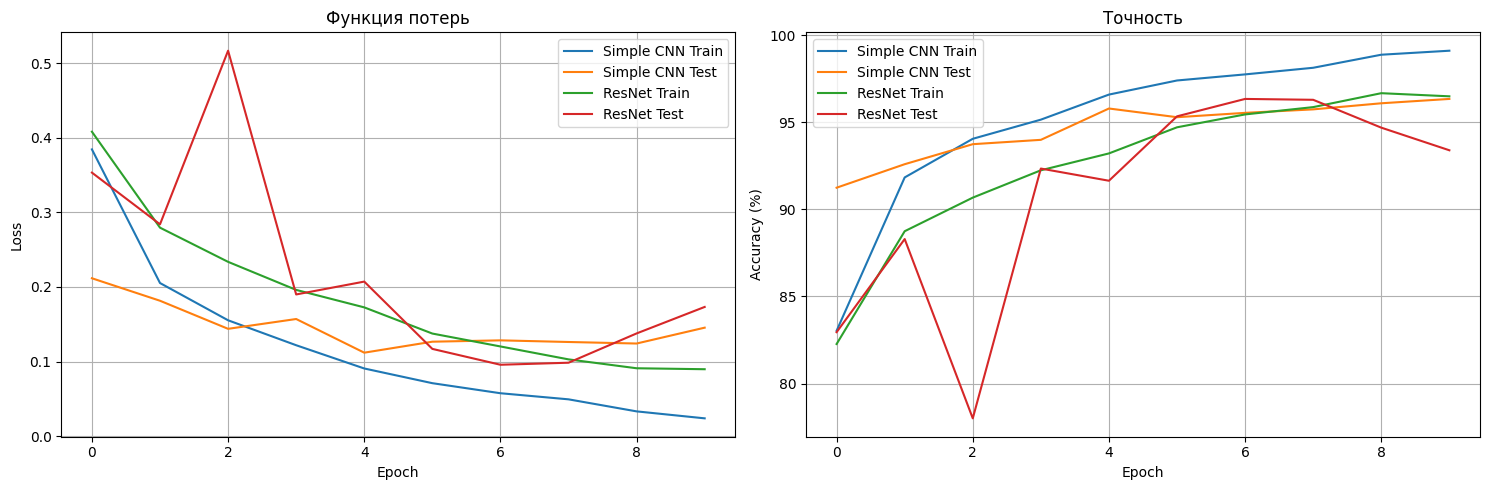

In [31]:
# Визуализация кривых обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_train_loss, label='Simple CNN Train')
plt.plot(cnn_test_loss, label='Simple CNN Test')
plt.plot(resnet_train_loss, label='ResNet Train')
plt.plot(resnet_test_loss, label='ResNet Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Функция потерь')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cnn_train_acc, label='Simple CNN Train')
plt.plot(cnn_test_acc, label='Simple CNN Test')
plt.plot(resnet_train_acc, label='ResNet Train')
plt.plot(resnet_test_acc, label='ResNet Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Точность')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


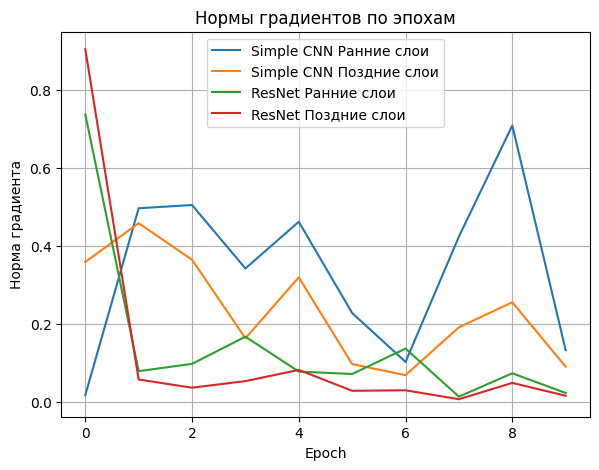

In [33]:
# Анализ градиентов
def analyze_gradients(gradients_list, model_name):
    early_layers = []
    late_layers = []
    
    for epoch_grads in gradients_list:
        early_norms = []
        late_norms = []
        
        for name, grad_norm in epoch_grads.items():
            if 'conv1' in name or 'layer1' in name:
                early_norms.append(grad_norm)
            elif 'layer3' in name or 'fc' in name:
                late_norms.append(grad_norm)
        
        if early_norms:
            early_layers.append(np.mean(early_norms))
        if late_norms:
            late_layers.append(np.mean(late_norms))
    
    return early_layers, late_layers

cnn_early, cnn_late = analyze_gradients(cnn_gradients, "CNN")
resnet_early, resnet_late = analyze_gradients(resnet_gradients, "ResNet")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
if cnn_early and cnn_late:
    plt.plot(cnn_early, label='Simple CNN Ранние слои')
    plt.plot(cnn_late, label='Simple CNN Поздние слои')
if resnet_early and resnet_late:
    plt.plot(resnet_early, label='ResNet Ранние слои')
    plt.plot(resnet_late, label='ResNet Поздние слои')
plt.xlabel('Epoch')
plt.ylabel('Норма градиента')
plt.title('Нормы градиентов по эпохам')
plt.legend()
plt.grid(True)

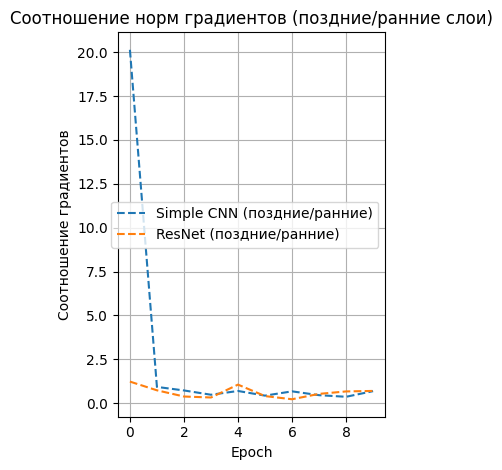

In [34]:
# Сравнение соотношения градиентов
plt.subplot(1, 2, 2)
if cnn_early and cnn_late and len(cnn_early) == len(cnn_late):
    cnn_ratio = [late/early if early > 0 else 0 for early, late in zip(cnn_early, cnn_late)]
    plt.plot(cnn_ratio, label='Simple CNN (поздние/ранние)', linestyle='--')
if resnet_early and resnet_late and len(resnet_early) == len(resnet_late):
    resnet_ratio = [late/early if early > 0 else 0 for early, late in zip(resnet_early, resnet_late)]
    plt.plot(resnet_ratio, label='ResNet (поздние/ранние)', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Соотношение градиентов')
plt.title('Соотношение норм градиентов (поздние/ранние слои)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

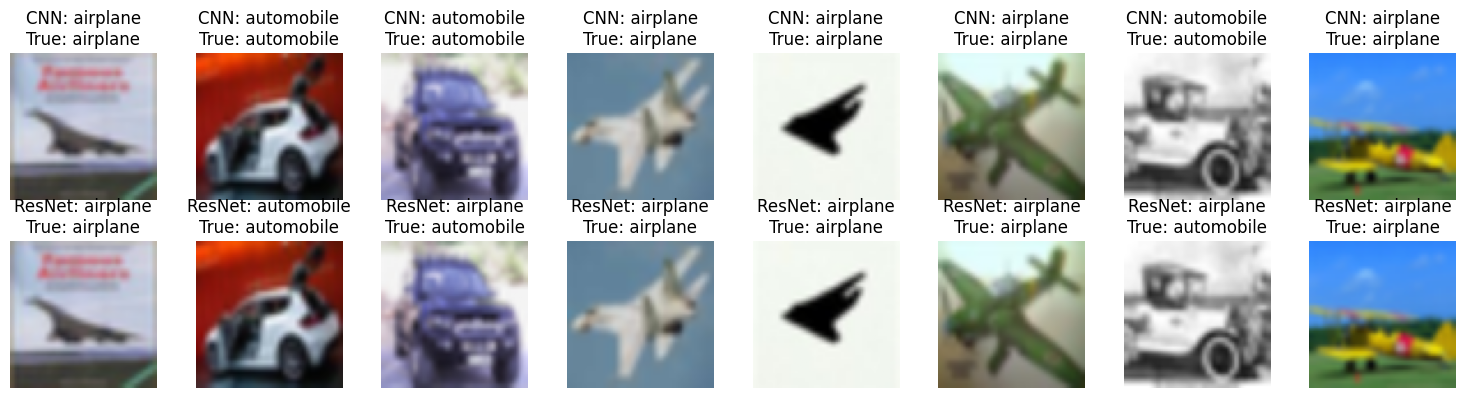

In [35]:
def test_models_on_examples(model_cnn, model_resnet, testloader, classes):
    model_cnn.eval()
    model_resnet.eval()
    
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs_cnn = model_cnn(images)
        outputs_resnet = model_resnet(images)
        
        _, preds_cnn = outputs_cnn.max(1)
        _, preds_resnet = outputs_resnet.max(1)
    
    # Визуализация результатов
    fig, axes = plt.subplots(2, 8, figsize=(15, 4))
    
    for i in range(8):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5  # денормализация
        
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'CNN: {classes[preds_cnn[i].item()]}\nTrue: {classes[labels[i].item()]}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'ResNet: {classes[preds_resnet[i].item()]}\nTrue: {classes[labels[i].item()]}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

class_names = ['airplane', 'automobile']
test_models_on_examples(simple_cnn, resnet, testloader, class_names)

## Выводы

1. **Проблема затухающих градиентов**:
   - В простой CNN наблюдается более сильное затухание градиентов в глубоких слоях
   - Градиенты в поздних слоях простой CNN значительно меньше, чем в ранних

2. **Эффект skip connections в ResNet**:
   - ResNet демонстрирует более сбалансированное распределение градиентов
   - Skip connections позволяют градиентам напрямую проходить в более ранние слои
   - Соотношение градиентов поздние/ранние слои выше в ResNet

3. **Влияние на обучение**:
   - ResNet показывает более стабильное обучение и сходимость
   - Простая CNN может страдать от медленного обучения глубоких слоев
   - Skip connections решают проблему исчезающих градиентов

4. **Практические преимущества ResNet**:
   - Возможность обучения очень глубоких сетей
   - Улучшенная передача градиентов через все слои сети
   - Более эффективное использование параметров сети